<a href="https://colab.research.google.com/github/RL-Starterpack/rl-starterpack/blob/main/exercises/AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL Tutorial - **Bandits Exercise**


## Setup

In [1]:
#@title Run this cell to clone the RL tutorial repository and install it
try:
  import rl_starterpack
  print('RL-Starterpack repo succesfully installed!')
except ImportError:
  print('Cloning RL-Starterpack package...')

  # !git clone https://github.com/RL-Starterpack/rl-starterpack.git
  print('Installing RL-StarterPack package...')
  !pip install -e rl-starterpack[full] &> /dev/null
  print('\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('Please restart the runtime to use the newly installed package!')
  print('Runtime > Restart Runtime')
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

Cloning RL-Starterpack package...
Installing RL-StarterPack package...


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Please restart the runtime to use the newly installed package!
Runtime > Restart Runtime
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [1]:
from typing import List, Optional, Tuple, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

As a first step, let's do some experimentation setup. The crucial thing we need is a **test bed**. The test bed is the object where we define the arms, the reward distributions for each arm and how to conduct an experiment on the arms.

We will provide some parameters to play with. Specifically, we can change the number of arms, the parameters of the distribution from which the 

In [2]:
# PARAMETERS
num_arms = 10               # number of arms in the test bed
reward_mean = 1             # mean of normal distribution from which mean reward of each arm will be drawn
reward_std = 1              # std of normal distribution from which mean reward of each arm will be drawn

In [5]:
class TestBed:

    def __init__(self, num_arms: int=10, reward_mean: Union[int, float]=0, reward_std: Union[int, float]=1) -> 'TestBed':
        self.seed = np.random.choice(1000000)
        self.reward_mean = reward_mean
        self.reward_std = reward_std
        self.num_arms = num_arms

        np.random.seed(self.seed)
        self.mean_rewards = np.random.normal(reward_mean, reward_std, num_arms)

    def draw_arm(self, idx: int) -> float:
        mu = self.mean_rewards[idx]
        return np.random.normal(mu, self.reward_std)

    def visualise(self) -> None:
        dummies = np.random.normal(0, 1, 1000)
        dfs = []
        for arm, mu in enumerate(self.mean_rewards):
            dfs.append(pd.DataFrame({'Arm': arm, 'Reward Distribution': dummies + mu}))

        dfs = pd.concat(dfs)
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.violinplot(data=dfs, x='Arm', y='Reward Distribution', width=0.3, ax=ax)
        plt.show()




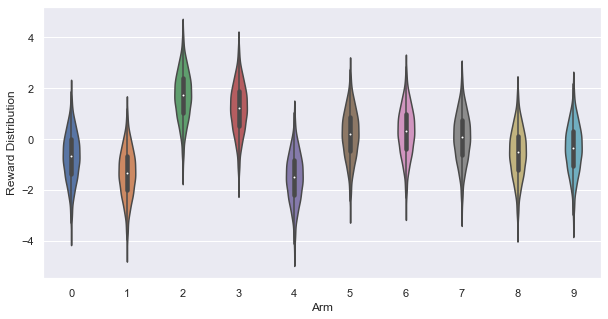

In [6]:
testbed = TestBed()
testbed.visualise()

In [19]:
class Experiment:
    
    def __init__(self, testbed: TestBed, policy: callable, init_rewards: Optional[float]=0) -> None:
        self.testbed = testbed
        self.policy = policy
        self.init_rewards = init_rewards
        self._init_fields()

    def _init_fields(self) -> None:
        self.observed_rewards = []
        self.expected_rewards = self.init_rewards * np.ones(self.testbed.num_arms)
        self.observed_draws = []
        self.num_draws = np.zeros(self.testbed.num_arms)
        self.total_draws = 0

    def step(self) -> Tuple[int, float]:
        chosen_arm = self.policy(self.expected_rewards, self.total_draws)
        reward = self.testbed.draw_arm(chosen_arm)

        self.total_draws += 1
        self.observed_draws.append(chosen_arm)
        self.num_draws[chosen_arm] += 1
        self.observed_rewards.append(reward)
        self.expected_rewards[chosen_arm] += (1. / (self.num_draws[chosen_arm] + 1)) * (reward - self.expected_rewards[chosen_arm])

        if self.total_draws < 50:
            print(chosen_arm, reward)
            print(self.expected_rewards)
        return chosen_arm, reward

    def run_episode(self, horizon: int) -> None:
        for i in range(horizon):
            _ = self.step()

    def reset(self) -> None:
        self._init_fields()

    def visualise(self) -> None:
        fig, ax = plt.subplots(figsize=(15, 10), nrows=3, ncols=1)

        reward_df = pd.DataFrame({'timestep': range(len(self.observed_rewards)), 'reward': self.observed_rewards})
        sns.lineplot(data=reward_df, x='timestep', y='reward', ax=ax[0])

        sns.violinplot(x=self.observed_draws, y=self.observed_rewards, width=0.3, ax=ax[1])
        ax[1].set_ylabel('reward')
        ax[1].set_xlabel('arm')

        arms, counts = np.unique(self.observed_draws, return_counts=True)
        sns.scatterplot(x=arms, y=counts, ax=ax[2])
        ax[2].set_ylim(0, len(self.observed_rewards))
        ax[2].set_ylabel('draws')
        ax[2].set_xlabel('arm')

        plt.show()



## POLICIES

### Explore Then Commit
In this policy we systematically explore each arm for a fixed number of rounds. After that, we exploit the best known arm for the remaining timesteps.

The hyperparameter for this policy will be the **number of rounds** for which we explore the arms. We can set this value to be anything between `1` (explore the arms for one round only) and `horizon / number_of_arms` (keep exploring the arms throughout).

Set the hyperparameter and implement the policy in the following cell.

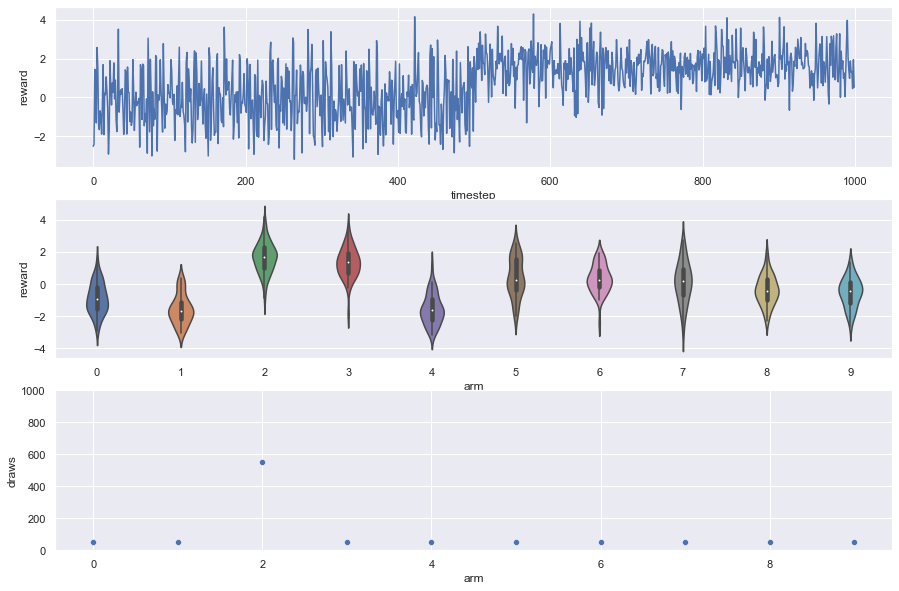

In [8]:
# Implement policy here
num_rounds = 50

def explore_then_commit(expected_rewards: List[float], num_draws: int, num_rounds: int=num_rounds) -> int:
    num_arms = len(expected_rewards)
    if num_draws < num_rounds * num_arms:
        return num_draws % num_arms

    max_indices = np.where(expected_rewards == max(expected_rewards))[0]
    return np.random.choice(max_indices)

# run experiment with policy
experiment = Experiment(testbed, explore_then_commit)
experiment.run_episode(horizon=1000)
experiment.visualise()

### $\epsilon$-greedy
In this policy, we either uniformly choose a random arm with a probability $ \epsilon \in (0,1)$ or choose the arm with best known expected reward.

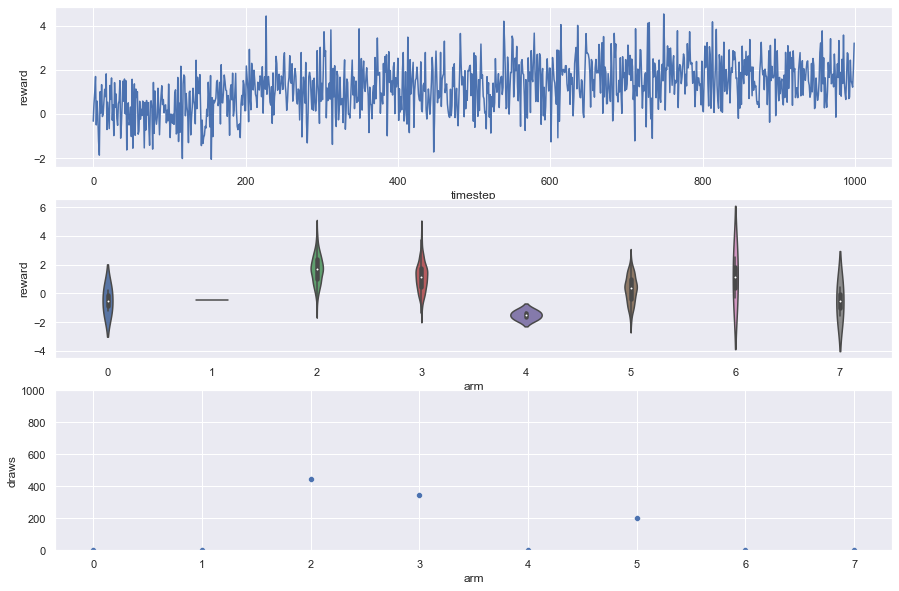

In [9]:
epsilon = 0.01

# IMPLEMENT policy here
def epsilon_greedy(expected_rewards: List[float], num_draws: int, epsilon: float=epsilon) -> int:
    if np.random.uniform() <= epsilon:
        choices = range(len(expected_rewards))
    else:
        choices = np.where(expected_rewards == max(expected_rewards))[0]
        
    arm = np.random.choice(choices)
    return arm

# run experiment with policy
experiment = Experiment(testbed, epsilon_greedy)
experiment.run_episode(horizon=1000)
experiment.visualise()

### Optimistic Initial Values
In this policy, we set the initial expected reward values to a **wildly optimistic high number**. The reasoning is, as we update the high initial expected rewards with the observed rewards, they will tend to lower values. In this setting, if we choose the arm with the highest expected reward, we will end up exploring the arms more until the arm with the best reward is found.

6 0.06723065937185821
[5.         5.         5.         5.         5.         5.
 2.53361533 5.         5.         5.        ]
9 0.20132591377868547
[5.         5.         5.         5.         5.         5.
 2.53361533 5.         5.         2.60066296]
5 0.8127459151540048
[5.         5.         5.         5.         5.         2.90637296
 2.53361533 5.         5.         2.60066296]
1 -0.26029952628728403
[5.         2.36985024 5.         5.         5.         2.90637296
 2.53361533 5.         5.         2.60066296]
4 -1.9567021719122542
[5.         2.36985024 5.         5.         1.52164891 2.90637296
 2.53361533 5.         5.         2.60066296]
8 1.004070951338593
[5.         2.36985024 5.         5.         1.52164891 2.90637296
 2.53361533 5.         3.00203548 2.60066296]
2 3.1950483538997716
[5.         2.36985024 4.09752418 5.         1.52164891 2.90637296
 2.53361533 5.         3.00203548 2.60066296]
7 -1.1991114447638707
[5.         2.36985024 4.09752418 5.         1.52164

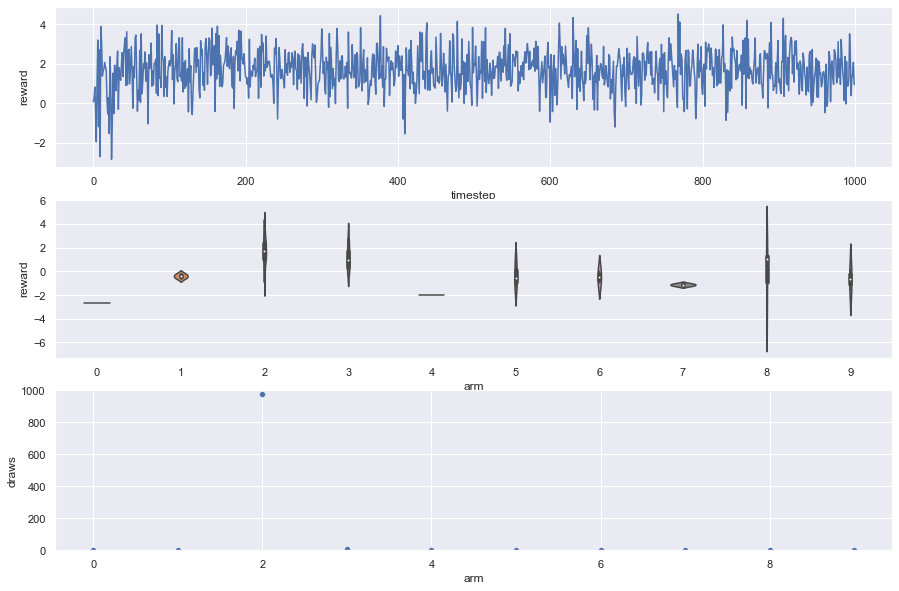

In [20]:
optimistic_initial_reward = 5

# IMPLEMENT policy here
def optimistic_initial_values(expected_rewards: List[float], num_draws: int) -> int:
    max_reward_arms = np.where(expected_rewards == max(expected_rewards))[0]
    return np.random.choice(max_reward_arms)

# run experiment with policy
experiment = Experiment(testbed, optimistic_initial_values, init_rewards=optimistic_initial_reward)
experiment.run_episode(horizon=1000)
experiment.visualise()
